## Automatic simulation

In this simulation we go directly from the patient coordinates to the MRI coordinates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print(f'added {module_path} to sys')
    sys.path.append(module_path)

In [2]:
from endosimutilities.end_utils import create_transform, \
                                  multiply_points_by_matrix, \
                                  multiply_point_by_matrix, pointer_to_mri,\
                                  camera_to_mri, mri_to_camera, add_noise_to_points,\
                                  add_noise_to_params, extract_rigid_body_parameters,\
                                  rigid_body_parameters_to_matrix, \
                                  convert_4x1_to_1x1x3, project_camera_point_to_image, \
                                  create_pnt_ref, create_pnt_ref_in_camera_space, create_pat_ref, \
                                  create_pat_ref_in_camera_space, get_ref_T_tip, calculate_euclid_dist, convert_points_nx3_to_1xnx3


In [3]:
# creating 4 points in patient coordinates

z = 200 # head length (about 20cm)
x = 250 # menton to top of head (about 25cm)
y = 150 # head bredth (about 15cm)


points = np.array(
[
    [-x,-y,z],
    [-x,y,z],
    [x,y,z],
    [x,-y,z],
])


cancer_point = convert_points_nx3_to_1xnx3(np.array([[0,0,0]]))

#points_converted = convert_points_nx3_to_1xnx3(points)


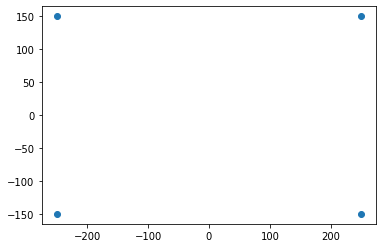

In [4]:
plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.show()

## projecting points from 3D to 2D

In [5]:
intrinsics = np.loadtxt('calibration/intrinsics.txt')
distortion = np.loadtxt('calibration/distortion.txt')

print("Intrinsics are:" + str(intrinsics))
print("Distortion coefficients are:" + str(distortion))


Intrinsics are:[[664.6329766    0.         931.53151205]
 [  0.         663.83211807 520.64004697]
 [  0.           0.           1.        ]]
Distortion coefficients are:[-4.0929449e-01  2.1631278e-01  1.1120000e-05  1.2712000e-03
 -7.2057120e-02]


In [6]:
points_converted = convert_points_nx3_to_1xnx3(points)

rvec = np.zeros((1,3))
tvec = np.zeros((1,3))
image_points, jacobian = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)

In [7]:
image_points = image_points.squeeze()
print(image_points)

[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]


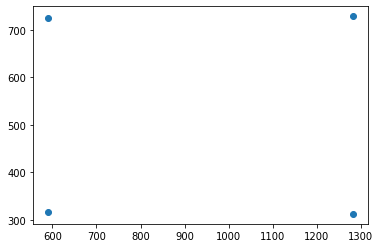

In [8]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.show()

# Simulation 1: adding noise to image points (2D)

First we add noise to the image points (that is- add noise in 2D)

In [9]:
image_points_noisy = add_noise_to_points(image_points,0.25)

We then find the corresponding transformation to get us from the 3D image points to the corresponding noisy image points

In [10]:
success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )

success, rotation_vector, translation_vector = cv2.solvePnP(points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )

if success_true:
    print(f'rotation true:, {rotation_vector_true}')
    print(f'translation true:, {translation_vector_true}')
else:
    print('solution not found')
    
if success:
    print(f'rotation:, {rotation_vector}')
    print(f'translation:, {translation_vector}')
else:
    print('solution not found')
    

        

rotation true:, [[-1.33849327e-04]
 [ 1.53026096e-02]
 [ 2.27516157e-07]]
translation true:, [[-2.08313803e+00]
 [-1.82287484e-02]
 [ 2.01168074e+02]]
rotation:, [[-0.00159775]
 [ 0.0157885 ]
 [-0.00021602]]
translation:, [[ -2.56418293]
 [ -0.4362066 ]
 [201.27419986]]


Finally we project the 3D points to 2D with the true and noisy rotation and translation

In [11]:
point_projected2D_true, jacobian = cv2.projectPoints(points_converted, rotation_vector_true, translation_vector_true, intrinsics, distortion)
point_projected2D_true = point_projected2D_true.squeeze()
print(point_projected2D_true)

point_projected2D, jacobian = cv2.projectPoints(points_converted, rotation_vector, translation_vector, intrinsics, distortion)
point_projected2D = point_projected2D.squeeze()
print(point_projected2D)



[[ 590.71083943  315.32212628]
 [ 590.68341083  726.00576517]
 [1281.25122558  729.16991962]
 [1281.22322562  312.15831522]]
[[ 590.54587779  315.46910164]
 [ 590.30104189  725.85256277]
 [1281.0469947   729.08948137]
 [1280.61572164  311.92086032]]


We can also use this rotation and translation to transform any other point in this coordinate system- eg. a point where the caner is locaed


In [12]:
cancer_projected2D_true, jacobian = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
cancer_projected2D_true = cancer_projected2D_true.squeeze()
print(cancer_projected2D_true)

cancer_projected2D, jacobian = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
cancer_projected2D = cancer_projected2D.squeeze()
print(cancer_projected2D)


[924.64967063 520.57989916]
[923.06524873 519.20151923]


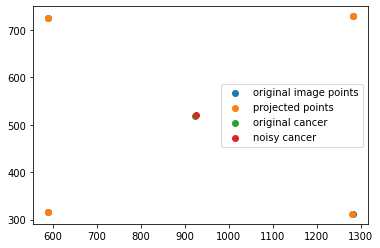

In [13]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.scatter(point_projected2D[:,0], point_projected2D[:,1])
#plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])

plt.scatter(cancer_projected2D[0], cancer_projected2D[1])
plt.scatter(cancer_projected2D_true[0], cancer_projected2D_true[1])

plt.legend(['original image points', 'projected points', 'original cancer', 'noisy cancer'])

plt.show()

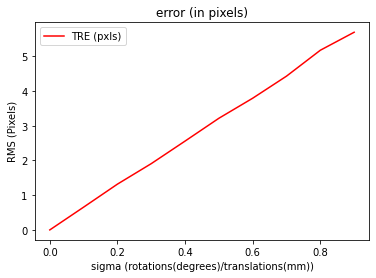

In [14]:

number_samples = 1000
x_values_px = []
y_values_px = []

x_values_mm = []
y_values_mm = []

for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # add noise to image points
        image_points_noisy = add_noise_to_points(image_points,sigma)
        
        # try and match noisy 2D to original 3d object points
        # true
        success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics,distortion, flags=0 )
        # noisy
        success, rotation_vector, translation_vector = cv2.solvePnP(points.astype('float32'), image_points_noisy.astype('float32'), intrinsics,distortion, flags=0 )

        
        # project cancer 3D point using the found rotations and translations
        # true
        point_projected2D_true, _ = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        point_projected2D_true = point_projected2D_true.squeeze()
        # noisy
        point_projected2D, _ = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
        point_projected2D = point_projected2D.squeeze()

        
        
        euclid_dist_px =  (point_projected2D_true[0] - point_projected2D[0]) \
                     * (point_projected2D_true[0] - point_projected2D[0]) \
                     + (point_projected2D_true[1] - point_projected2D[1]) \
                     * (point_projected2D_true[1] - point_projected2D[1]) 
        
        
        #euclid_dist_mm = calculate_euclid_dist()
        
        rms = rms + euclid_dist_px
        
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values_px.append(sigma)
    y_values_px.append(rms)
    
plt.plot(x_values_px, y_values_px, 'r', label='TRE (pxls)')
plt.title('error (in pixels)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (Pixels)')
plt.show()


## Simulation 2: adding noise to 3D


Add noise to the 3D points

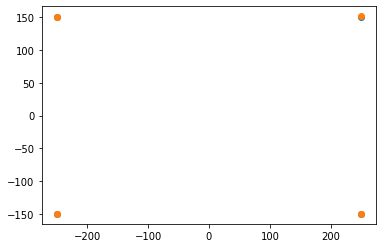

In [15]:
noisy_points = add_noise_to_points(points, 0.5)

plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.scatter(noisy_points[:,0], noisy_points[:,1])
plt.show()


Project both noisy points and real points to 2D

In [16]:
image_points, _ = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)
image_points_noisy, _ = cv2.projectPoints(noisy_points, rvec, tvec, intrinsics, distortion)
image_points = image_points.squeeze()
image_points_noisy = image_points_noisy.squeeze()

Find transformations to get from 3D to 2D

In [17]:
success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )

success, rotation_vector, translation_vector = cv2.solvePnP(noisy_points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )


Use these transformations to transform a cancer

In [18]:
cancer_projected2D_true, _ = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
cancer_projected2D_true = cancer_projected2D_true.squeeze()
print(cancer_projected2D_true)

cancer_projected2D, _ = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
cancer_projected2D = cancer_projected2D.squeeze()
print(cancer_projected2D)

[924.64967063 520.57989916]
[929.06433927 517.13588145]


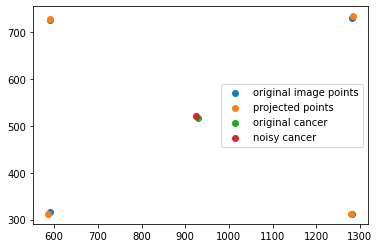

In [19]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])
#plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])

plt.scatter(cancer_projected2D[0], cancer_projected2D[1])
plt.scatter(cancer_projected2D_true[0], cancer_projected2D_true[1])

plt.legend(['original image points', 'projected points', 'original cancer', 'noisy cancer'])

plt.show()

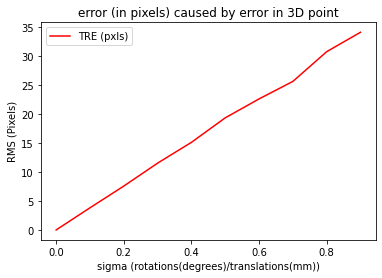

In [20]:

number_samples = 1000
x_values_px = []
y_values_px = []

x_values_mm = []
y_values_mm = []

for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # add noise to 3D points
        noisy_points = add_noise_to_points(points, sigma)
        
        # project both noisy and non-noisy 3D points to 2D
        image_points, _ = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)
        image_points_noisy, _ = cv2.projectPoints(noisy_points, rvec, tvec, intrinsics, distortion)
        image_points = image_points.squeeze()
        image_points_noisy = image_points_noisy.squeeze()
    
        
        # try and match noisy 2D to original 3d object points and get transformation
        # true
        success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )
        # noisy
        success, rotation_vector, translation_vector = cv2.solvePnP(noisy_points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )
        
        # project cancer 3D point using the found rotations and translations
        # true
        cancer_projected2D_true, _ = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        cancer_projected2D_true = cancer_projected2D_true.squeeze()
        # noisy
        cancer_projected2D, _ = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
        cancer_projected2D = cancer_projected2D.squeeze()

        
        euclid_dist_px =  (cancer_projected2D_true[0] - cancer_projected2D[0]) \
                     * (cancer_projected2D_true[0] - cancer_projected2D[0]) \
                     + (cancer_projected2D_true[1] - cancer_projected2D[1]) \
                     * (cancer_projected2D_true[1] - cancer_projected2D[1]) 
        
        
        #euclid_dist_mm = calculate_euclid_dist()
        
        rms = rms + euclid_dist_px
        
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values_px.append(sigma)
    y_values_px.append(rms)
    
plt.plot(x_values_px, y_values_px, 'r', label='TRE (pxls)')
plt.title('error (in pixels) caused by error in 3D point')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (Pixels)')
plt.show()


## Simulation 3: adding noise to both

[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]


[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]


[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]


[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]


[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]


[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]
[[ 590.69521249  315.28317659]
 [ 590.76928521  725.95821907]
 [1279.54260645  728.42152929]
 [1280.46190437  312.3810722 ]]
[[ 590.69938456  315.14734274]
 [ 590.77383988  725.96449344]
 [1279.77880453  728.23050654]
 [1280.65100568  312.44029298]]
[[ 590.19163178  315.05943337]
 [ 590.2555753   726.65289651]
 [1281.11734789  729.18879787]
 [1280.8672933   312.33691214]]
[[ 590.32183459  315.20216579]
 [ 590.22396888  726.55234411]
 [1280.98970633  729.26408979]
 [1280.82553711  312.43363517]]
[[ 590.31414688  314.69986621]
 [ 590.46925266  726.07506565]
 [1281.64567876  728.99798138]
 [1280.73477518  312.40789549]]
[[ 590.27573238  314.69077219]
 [ 590.70787374  725.97966503]
 [1281.50276478  729.16698821]
 [1280.51509201  312.45613074]]


[[ 591.74631524  315.8602497 ]
 [ 590.23394917  726.07169853]
 [1280.33334615  728.60356834]
 [1281.98610302  311.75131943]]
[[ 591.68102897  315.86354675]
 [ 590.18262443  726.10763257]
 [1280.17623573  728.5971493 ]
 [1282.12765224  311.82078708]]
[[ 590.5362116   315.35060996]
 [ 590.94843517  725.79357533]
 [1281.32059952  729.30680091]
 [1280.72889667  312.5291623 ]]
[[ 590.31768002  315.40102692]
 [ 590.98829286  725.88793862]
 [1281.53035606  729.54507204]
 [1280.79867176  312.40908562]]
[[ 589.93983704  315.07794455]
 [ 590.20380905  726.34646823]
 [1280.31350982  728.57537119]
 [1280.31113778  312.69936886]]
[[ 589.94297682  315.12187688]
 [ 590.19650831  726.29972937]
 [1280.22588986  728.66942508]
 [1280.3503472   312.83905432]]
[[ 589.46649403  314.59187351]
 [ 591.12167209  725.68642312]
 [1281.61676521  729.52809332]
 [1281.59759627  312.07037643]]
[[ 589.50242781  314.58558921]
 [ 591.23981268  725.69460964]
 [1281.56579258  729.50522157]
 [1281.55405241  312.01581608]]


[[ 591.15850585  315.64117112]
 [ 592.44254361  724.78914812]
 [1282.30759869  729.95899525]
 [1281.11636362  312.26347544]]
[[ 591.31960448  315.88182214]
 [ 592.41066005  725.04729516]
 [1282.3411725   730.0686727 ]
 [1281.26398573  312.37019166]]
[[ 589.62030902  314.51425437]
 [ 590.63091899  725.82299356]
 [1281.39173996  729.16133803]
 [1282.35686086  311.72389928]]
[[ 589.48803675  314.51611408]
 [ 590.70444995  725.76260373]
 [1281.25352555  729.03262845]
 [1282.20479248  311.79425322]]
[[ 589.43735577  314.5695936 ]
 [ 590.02979568  726.65691446]
 [1281.23487364  729.06184894]
 [1280.70378193  312.39274166]]
[[ 589.34268564  314.62966938]
 [ 590.04359159  726.63560488]
 [1281.18966174  729.05340417]
 [1280.69866245  312.30916219]]
[[ 591.49697677  315.49813764]
 [ 590.19081783  726.35170054]
 [1279.9347986   728.34548716]
 [1280.93369782  312.34198559]]
[[ 591.45819822  315.45865684]
 [ 590.23772071  726.23926783]
 [1280.03284398  728.36059455]
 [1281.00741864  312.29214574]]


[[ 591.38441914  315.6812907 ]
 [ 590.76825279  725.88807762]
 [1280.94453139  729.10184958]
 [1281.17311974  312.15816441]]
[[ 591.37544583  315.62277259]
 [ 590.6880446   725.87131579]
 [1280.9287186   729.20436977]
 [1281.1430298   312.22538172]]
[[ 591.7139305   316.03748549]
 [ 591.58111367  725.40616255]
 [1280.67224453  728.90791024]
 [1281.12818395  311.93730531]]
[[ 591.80660836  316.15980455]
 [ 591.67571198  725.30371315]
 [1280.47744054  729.07587824]
 [1280.99178648  311.90896026]]
[[ 589.49799304  314.43594099]
 [ 590.73341307  725.80346385]
 [1280.84438524  729.29332283]
 [1281.42596428  312.02348228]]
[[ 589.43740996  314.36484998]
 [ 590.76945177  725.98170803]
 [1280.71779088  729.26389282]
 [1281.64538023  312.12392647]]
[[ 590.39206674  315.34924007]
 [ 590.39156818  726.32426434]
 [1282.71208445  730.12490658]
 [1280.58038844  312.5343411 ]]
[[ 590.57356001  315.26850321]
 [ 590.52520999  726.33257617]
 [1282.65055715  729.97779869]
 [1280.61747919  312.50236831]]


[[ 590.00688522  314.98868463]
 [ 590.69925576  725.62867418]
 [1280.15007561  728.43869072]
 [1282.76582106  311.58157691]]
[[ 590.05074691  314.77381911]
 [ 590.84402156  725.53921488]
 [1280.11439549  728.36014936]
 [1282.57062562  311.54469436]]
[[ 591.06441717  315.82685269]
 [ 589.65651092  726.55755979]
 [1281.88419348  729.50411945]
 [1280.39391637  312.38637223]]
[[ 591.04009144  315.56138176]
 [ 589.74444056  726.56598751]
 [1282.1287107   729.33794123]
 [1280.52837248  312.32500224]]
[[ 591.41526617  315.39009789]
 [ 590.65656712  726.12922891]
 [1281.20820776  729.28524199]
 [1280.61604771  312.86772627]]
[[ 591.16147149  315.41146356]
 [ 590.56120087  726.2529925 ]
 [1281.29729013  729.22530964]
 [1280.53965044  312.94062983]]
[[ 590.46264605  315.26834127]
 [ 590.83537595  726.11369226]
 [1280.72149017  729.02601525]
 [1281.3634931   312.1294628 ]]
[[ 590.65461963  315.34377089]
 [ 590.7659407   726.08509928]
 [1280.76506565  728.99649852]
 [1281.2539178   312.21020323]]


[[ 588.92077702  314.24177396]
 [ 588.67518352  727.13999449]
 [1281.06681021  729.11178375]
 [1283.35327465  310.93591893]]
[[ 588.73253542  314.15962681]
 [ 588.4005117   727.12132401]
 [1280.80632221  728.83446549]
 [1282.79023811  311.07896475]]
[[ 591.68649974  316.2165721 ]
 [ 591.21578132  725.32449723]
 [1278.86744091  727.64229956]
 [1281.2872463   312.33992071]]
[[ 591.70638473  316.22164562]
 [ 591.33597355  725.18310031]
 [1279.10783711  727.89071219]
 [1281.43298853  312.37287631]]
[[ 588.89089219  314.93837745]
 [ 589.93061957  725.87783534]
 [1281.72272004  729.42730091]
 [1281.2219849   311.90848649]]
[[ 589.22565818  315.03617368]
 [ 589.96798426  725.6089766 ]
 [1281.69130683  729.73076768]
 [1280.8188638   311.99841103]]
[[ 592.06037947  315.96940864]
 [ 592.44613852  724.9819962 ]
 [1278.51292898  727.55205748]
 [1282.1411264   311.80715116]]
[[ 591.93468681  315.95473706]
 [ 592.18319831  724.72720121]
 [1278.30048018  727.68660262]
 [1282.29194667  311.83432433]]


[[ 591.45504744  316.0904848 ]
 [ 586.83114047  728.66070536]
 [1283.00615     730.27989692]
 [1282.54879593  311.77206589]]
[[ 591.37142876  315.95666045]
 [ 586.60445193  728.72344399]
 [1283.08446009  730.14348617]
 [1282.60666615  311.88540893]]
[[ 593.39703815  316.88331625]
 [ 591.72543562  726.05300663]
 [1281.57179927  729.76660773]
 [1279.71948478  313.28807661]]
[[ 593.57945882  316.77400412]
 [ 591.40681411  725.76128693]
 [1281.54608572  729.50413725]
 [1279.48553495  313.15102019]]
[[ 588.7906635   313.82043688]
 [ 590.42504322  725.46349628]
 [1280.76823115  729.09767165]
 [1281.34162258  312.2058991 ]]
[[ 588.73150661  313.98340803]
 [ 590.17593583  725.32181767]
 [1280.67712865  729.09791376]
 [1281.40796371  312.01319686]]
[[ 592.91605002  316.68618749]
 [ 588.80935482  726.85804715]
 [1280.4183498   728.82742813]
 [1281.82073586  311.89094789]]
[[ 593.04704365  316.55957851]
 [ 588.77601085  726.68807813]
 [1280.92916567  728.8728407 ]
 [1281.71024115  311.44431925]]


[[ 591.92668329  315.95642307]
 [ 591.17280938  725.49182514]
 [1280.48753441  728.7282588 ]
 [1280.95621133  312.37415325]]
[[ 591.85635089  315.5700735 ]
 [ 590.87954704  725.33728371]
 [1280.48178921  728.8060144 ]
 [1281.31743822  312.24842597]]
[[ 592.00396364  316.33842709]
 [ 590.66837445  725.86922244]
 [1280.48217808  728.25724575]
 [1280.5660349   312.25582787]]
[[ 591.83604313  316.36247269]
 [ 590.57819846  726.11324069]
 [1280.25272723  728.07377664]
 [1280.21868429  312.04796161]]
[[ 590.56475863  315.13198767]
 [ 592.0228877   725.33886673]
 [1280.13693319  728.36104549]
 [1281.97017362  311.67084486]]
[[ 590.48760441  315.22575493]
 [ 592.15750606  725.15535072]
 [1280.58921168  728.6568756 ]
 [1281.92172893  311.54817106]]
[[ 590.4658399   315.03994892]
 [ 591.02187986  725.65521365]
 [1279.21116576  727.74948164]
 [1281.19422956  312.50743366]]
[[ 590.50805779  314.66660899]
 [ 590.63261062  725.78047613]
 [1279.03859979  727.63014548]
 [1281.35248877  312.21033393]]


[[ 591.96574297  316.34616213]
 [ 593.1473592   724.18085796]
 [1283.89506905  730.596263  ]
 [1281.34581566  311.99762789]]
[[ 591.99338177  316.24557099]
 [ 593.27252299  724.49173343]
 [1283.86924551  730.79658606]
 [1281.52511774  311.65859793]]
[[ 591.06370114  315.56904134]
 [ 590.94229173  726.10373286]
 [1282.09611638  729.21521496]
 [1280.69257973  313.2902237 ]]
[[ 590.87654994  315.27431488]
 [ 591.11004061  725.94323526]
 [1282.22276312  729.62888972]
 [1280.70930284  313.06571112]]
[[ 592.75942324  316.35444359]
 [ 591.73310296  725.35668565]
 [1282.38706945  730.14636993]
 [1279.52296373  313.09433062]]
[[ 593.0678805   316.29063887]
 [ 591.70199637  725.4248451 ]
 [1282.27969673  730.03621413]
 [1279.78835341  313.04798828]]
[[ 591.29871328  315.93450864]
 [ 590.21409759  726.02160452]
 [1283.09303959  730.58969068]
 [1281.77586328  311.91595747]]
[[ 591.02172249  315.8297632 ]
 [ 590.16928129  725.98902052]
 [1283.27198389  730.4614304 ]
 [1281.74500031  312.051973  ]]


[[ 588.88877547  313.89201873]
 [ 591.35654182  725.44526821]
 [1281.69081378  729.92113836]
 [1281.17661461  311.9961034 ]]
[[ 588.8847876   314.16613803]
 [ 591.13213436  725.24233772]
 [1281.63086101  730.15723425]
 [1281.21319735  311.4323736 ]]
[[ 591.29734988  316.43980954]
 [ 591.39083651  725.30566741]
 [1282.10355513  729.133793  ]
 [1282.22518041  311.68908316]]
[[ 591.29523857  316.72542773]
 [ 591.56275804  725.29720113]
 [1282.2327037   728.83461121]
 [1282.18091509  311.35806927]]
[[ 592.54447717  316.93378458]
 [ 590.34324646  725.83593051]
 [1280.76554964  729.29180061]
 [1280.18404182  312.15281888]]
[[ 592.42822123  316.70698135]
 [ 590.1507618   725.60385405]
 [1280.90623684  729.30027745]
 [1280.21274351  312.41886918]]
[[ 589.85035169  314.80100525]
 [ 591.07475926  725.6138193 ]
 [1281.09166789  728.5348422 ]
 [1281.89674421  311.68813041]]
[[ 589.8674996   314.96909682]
 [ 591.19716621  725.62755341]
 [1281.15634541  728.70935698]
 [1281.76545525  311.47818154]]


[[ 589.8039997   315.30527091]
 [ 590.1151761   726.16265469]
 [1284.3655256   730.89973556]
 [1283.53929886  310.40223117]]
[[ 589.79985569  315.43395871]
 [ 590.16690751  726.58207221]
 [1284.25405902  730.82084932]
 [1283.31011748  310.68716213]]
[[ 590.11146281  314.96129863]
 [ 591.07228223  726.49806285]
 [1281.08497359  727.98236279]
 [1282.26981159  311.7363778 ]]
[[ 590.10859436  314.66069439]
 [ 590.66973089  726.37714072]
 [1281.07961006  727.66122434]
 [1282.03900845  312.3391604 ]]
[[ 591.7945428   315.10497597]
 [ 590.69766903  726.28260628]
 [1283.1932754   729.88647691]
 [1280.47808276  311.98507469]]
[[ 592.51798358  314.93901603]
 [ 590.38754467  726.04817926]
 [1283.61305095  729.92066766]
 [1280.79321617  312.39958072]]
[[ 593.15507777  317.25315344]
 [ 592.18800999  724.8046001 ]
 [1281.7936484   729.95855037]
 [1281.92025528  311.72583885]]
[[ 593.83800672  316.97211627]
 [ 592.11932621  724.82391426]
 [1281.88607713  729.76529465]
 [1282.29082025  311.63268727]]


[[ 590.83196791  315.73358577]
 [ 593.59378339  724.08440365]
 [1280.42637519  729.24231827]
 [1281.78100015  311.63657513]]
[[ 591.10271046  316.27270788]
 [ 593.69929627  723.6193436 ]
 [1280.23103354  729.03220295]
 [1281.72836789  311.47290034]]
[[ 588.74922021  314.40490654]
 [ 589.33596955  727.03847381]
 [1281.67645724  729.63884542]
 [1282.98519933  311.3074984 ]]
[[ 588.92686779  314.31730677]
 [ 589.36939928  727.1280038 ]
 [1281.84861007  729.44142386]
 [1283.73428126  310.84255009]]
[[ 591.21315006  315.94164496]
 [ 590.21735071  726.61956286]
 [1281.47756586  729.3869331 ]
 [1282.54818906  311.29706081]]
[[ 591.04414077  315.65776897]
 [ 590.32491646  726.67803598]
 [1281.78268446  729.46010497]
 [1282.24150194  311.0120728 ]]
[[ 586.03469119  313.09233011]
 [ 592.62071229  724.65098867]
 [1280.94356514  729.08421472]
 [1279.6631374   313.14156928]]
[[ 585.9367505   313.77306896]
 [ 592.32170008  724.45619522]
 [1281.10039249  728.99388775]
 [1279.71870857  312.49643684]]


[[ 588.66640374  314.67439905]
 [ 592.65401306  725.19411346]
 [1281.95476719  729.85041004]
 [1284.31685135  310.44212351]]
[[ 588.15722581  314.62033163]
 [ 593.09543173  724.9112902 ]
 [1282.12926592  729.14808975]
 [1284.09093008  310.5077206 ]]
[[ 590.67908104  315.61113561]
 [ 592.06918055  725.39722395]
 [1277.14467274  726.55573037]
 [1282.17154284  311.78249436]]
[[ 590.53904201  316.11248033]
 [ 592.11057999  724.9216541 ]
 [1276.78492989  726.3107102 ]
 [1282.33611145  312.3243894 ]]
[[ 589.25722565  314.30735852]
 [ 589.38989017  726.58509736]
 [1280.34554135  728.14858688]
 [1278.14869677  314.0029081 ]]
[[ 590.00370666  314.31581277]
 [ 589.5582854   726.90763472]
 [1280.58126316  728.20994932]
 [1277.7876757   314.24425529]]
[[ 591.0583857   315.86333712]
 [ 589.2927379   727.65960372]
 [1282.28547935  729.31661628]
 [1280.06631987  313.37941929]]
[[ 590.73627025  315.92134986]
 [ 588.69025027  727.10793685]
 [1282.25347607  729.43093514]
 [1280.43348815  313.40787761]]


[[ 594.09326069  317.68031585]
 [ 594.65909784  723.98643038]
 [1280.05136326  728.54383213]
 [1279.78195927  312.82674063]]
[[ 593.65265009  317.93563252]
 [ 594.5046787   723.59449012]
 [1279.88990792  728.3218084 ]
 [1279.9937545   312.31694718]]
[[ 591.11663672  315.26648701]
 [ 594.18734252  723.96923104]
 [1278.73313895  727.86028301]
 [1285.32899934  308.98638739]]
[[ 590.67176175  315.18119969]
 [ 594.00403911  723.67067771]
 [1278.56105533  727.60585029]
 [1285.51062205  309.4621066 ]]
[[ 588.20360389  313.44574283]
 [ 589.24383157  726.425569  ]
 [1278.46751185  727.46041216]
 [1279.41721759  313.55342072]]
[[ 588.35331603  312.80056813]
 [ 589.34440197  726.4496369 ]
 [1278.29442187  727.44738923]
 [1279.38565182  313.1976838 ]]
[[ 591.48398993  315.56294834]
 [ 596.99383253  722.55634969]
 [1289.58652908  734.96350267]
 [1282.61391419  311.66656981]]
[[ 591.38220541  315.31013095]
 [ 597.08467322  722.5220233 ]
 [1289.5591173   734.71950904]
 [1282.46714153  312.24046592]]


[[ 588.91492302  315.25788618]
 [ 589.50204346  726.34195969]
 [1281.76967976  729.65766224]
 [1282.19430841  312.01236694]]
[[ 589.05823887  314.99614742]
 [ 589.26370529  726.23861437]
 [1281.80166848  729.74247096]
 [1282.08765136  312.3946644 ]]
[[ 592.92995697  316.69802245]
 [ 590.81037366  724.6894548 ]
 [1282.02495498  729.58733475]
 [1277.43108369  313.90768702]]
[[ 592.94223545  317.17478278]
 [ 590.89442395  724.76893504]
 [1281.82520313  728.81758765]
 [1277.77849918  313.63638358]]
[[ 590.89529589  314.72407961]
 [ 591.44299948  725.44146805]
 [1280.75165309  728.80214676]
 [1282.45562757  311.13490424]]
[[ 590.72410406  314.21733647]
 [ 591.28617501  725.8062224 ]
 [1280.20511844  729.24842097]
 [1283.01658084  311.76649172]]
[[ 591.8577792   316.25033421]
 [ 592.34292381  724.57134058]
 [1277.07719473  727.69042801]
 [1276.32697347  315.58289288]]
[[ 591.90196713  316.59382539]
 [ 592.32910438  724.86590129]
 [1276.8819478   727.33810743]
 [1276.39543274  315.14950523]]


[[ 599.66672621  320.02069368]
 [ 590.5850975   725.722929  ]
 [1284.52000964  731.23797394]
 [1284.81626676  309.82075152]]
[[ 600.00665368  320.39182747]
 [ 591.17436465  726.05067107]
 [1284.51990151  730.84619819]
 [1285.01835639  310.03804923]]
[[ 583.36521792  311.18005363]
 [ 591.00123384  725.01535361]
 [1283.06843886  730.677847  ]
 [1279.53558147  313.2822418 ]]
[[ 583.52135446  310.99771997]
 [ 591.20433534  725.22042387]
 [1283.59050833  730.42788732]
 [1278.62243798  313.71756796]]
[[ 591.59431313  316.33077982]
 [ 591.52227934  724.53197867]
 [1275.20499642  725.14250433]
 [1281.30945283  312.45479399]]
[[ 591.6015858   316.02239206]
 [ 591.43076995  724.07025675]
 [1275.74710958  725.40021341]
 [1281.01733113  311.90173781]]
[[ 592.10005397  316.48569047]
 [ 585.8911256   729.40708979]
 [1272.92409073  723.9869503 ]
 [1288.72415778  307.89305071]]
[[ 591.61291122  316.87218336]
 [ 586.24528022  729.34398714]
 [1273.37214084  723.96643269]
 [1288.15806298  307.72030742]]


[[ 592.14909696  315.94046064]
 [ 590.04433241  726.12346674]
 [1281.38742675  729.52137625]
 [1279.99391602  313.07233678]]
[[ 592.17232458  316.70899368]
 [ 589.23401407  725.86502026]
 [1280.85856519  729.69672285]
 [1279.37230907  312.55250052]]
[[ 593.37745311  316.65076931]
 [ 593.83397129  723.62887223]
 [1282.18280537  730.10300188]
 [1279.73862695  312.82079985]]
[[ 592.97782396  316.0472029 ]
 [ 593.95900702  723.94470918]
 [1281.85369433  729.89905796]
 [1279.19420419  313.07269832]]
[[ 587.53482141  314.03427971]
 [ 588.44824522  727.77065943]
 [1273.44725739  724.67484773]
 [1285.16580115  309.91113641]]
[[ 587.74933639  313.24972933]
 [ 588.52344096  728.09112186]
 [1273.94644565  725.01702998]
 [1285.20620099  310.57153354]]
[[ 587.87842912  314.98800191]
 [ 591.06123058  724.75072938]
 [1280.29867481  728.83316216]
 [1275.37429856  314.24500409]]
[[ 587.76756038  315.14734286]
 [ 591.52479054  725.26108271]
 [1280.2912096   728.89713238]
 [1275.20914671  314.69833513]]


[[ 584.29501576  311.48925438]
 [ 589.40361055  727.0336159 ]
 [1275.75076805  725.1459592 ]
 [1280.37811035  312.07780449]]
[[ 584.42398094  311.0762782 ]
 [ 589.58059265  727.51998494]
 [1276.52246039  725.10564035]
 [1280.18859953  311.73381168]]
[[ 591.95882167  316.51246643]
 [ 585.18655147  730.72921177]
 [1283.18239282  731.33031359]
 [1282.70809905  310.96721887]]
[[ 592.59509074  316.22026017]
 [ 585.23005025  731.26903314]
 [1283.35255636  731.00076378]
 [1282.97758944  310.44078003]]
[[ 594.92635183  317.32858331]
 [ 596.27893941  721.88815864]
 [1279.87071262  727.33344145]
 [1278.9921119   312.83577806]]
[[ 594.85370587  317.45698542]
 [ 595.55510367  721.36863991]
 [1279.7775648   727.40656603]
 [1279.64093057  312.77029766]]
[[ 593.23560764  316.90749538]
 [ 590.49813737  725.6214988 ]
 [1282.71524771  729.42013057]
 [1277.78933796  314.86514782]]
[[ 592.82031221  316.70624086]
 [ 591.58699826  725.33290314]
 [1282.98678861  729.34546713]
 [1278.20922833  314.51921741]]


[[ 589.79588748  315.23089197]
 [ 593.95566871  724.65966731]
 [1284.73622288  731.24540832]
 [1281.01716745  312.22802099]]
[[ 590.35381599  315.16224134]
 [ 594.38898606  724.84985965]
 [1284.72409544  731.593572  ]
 [1280.87329032  312.80163504]]
[[ 592.52444287  317.33688324]
 [ 592.29605309  723.10002458]
 [1281.46695868  728.93572947]
 [1279.51296084  313.56473895]]
[[ 592.67940859  317.39488275]
 [ 592.23119016  723.04907132]
 [1281.11154618  729.03673299]
 [1280.30393798  313.67650115]]
[[ 597.92819178  319.77717799]
 [ 588.05922211  727.25749315]
 [1277.03324624  726.36267008]
 [1279.57535887  313.45674454]]
[[ 597.50117147  319.78703022]
 [ 588.23230349  727.00984669]
 [1277.53250732  726.76110969]
 [1279.38503241  313.02651206]]
[[ 590.10828669  314.25239016]
 [ 588.91971304  727.74721079]
 [1278.46287987  728.45728545]
 [1276.58132819  314.00292789]]
[[ 589.90709854  314.50725115]
 [ 589.44158039  727.61424997]
 [1279.18401192  728.29178813]
 [1276.81227823  313.94684878]]


[[ 589.12679413  312.3989277 ]
 [ 592.98152482  724.93830056]
 [1284.62596777  731.43837714]
 [1279.95519115  313.33666662]]
[[ 588.99799614  312.44064221]
 [ 593.11927859  724.80174938]
 [1284.39677494  731.34422723]
 [1279.88690477  313.17197612]]
[[ 592.25943241  315.27606671]
 [ 594.75445705  724.22377907]
 [1278.22414564  728.42595012]
 [1276.48604139  314.0712248 ]]
[[ 592.53149085  314.99829351]
 [ 594.66508882  724.39459906]
 [1278.08002767  728.14577584]
 [1276.83120334  314.30915407]]
[[ 595.02835568  317.97198915]
 [ 593.47135903  725.60749844]
 [1280.0233004   728.33772082]
 [1281.49557126  312.56218329]]
[[ 595.05161322  317.30012705]
 [ 593.26159534  725.67412786]
 [1280.67793915  728.46845153]
 [1281.43820484  312.94397946]]
[[ 591.68955767  316.66712195]
 [ 594.93395118  723.87652143]
 [1280.56317097  728.10222897]
 [1277.17208326  314.05292044]]
[[ 591.39115496  316.03199517]
 [ 594.91219786  724.1352849 ]
 [1280.41790214  728.69472507]
 [1277.52918201  313.2523867 ]]


[[ 598.4603196   319.44922957]
 [ 585.66597545  728.20868158]
 [1276.41276797  727.57676636]
 [1277.75876176  314.08829957]]
[[ 598.44414381  319.04015458]
 [ 586.61517671  728.00968625]
 [1275.96910118  728.17716394]
 [1276.48296964  313.71727874]]
[[ 594.52557388  316.75102785]
 [ 590.69376508  725.43312067]
 [1281.16872423  728.99548372]
 [1276.98563082  314.13131827]]
[[ 594.48055781  316.764129  ]
 [ 590.81949552  724.67978576]
 [1280.96448325  728.43853398]
 [1276.6697396   314.7010004 ]]
[[ 589.36447896  314.45449262]
 [ 591.74232561  724.75632358]
 [1286.5691797   732.47789568]
 [1278.23195469  314.01578285]]
[[ 588.56512768  314.03336162]
 [ 591.83247846  724.98122652]
 [1287.41799619  731.66926145]
 [1278.64933677  314.55924241]]
[[ 589.63818493  314.81326987]
 [ 590.37585375  726.145119  ]
 [1280.75012195  728.84217603]
 [1279.86378812  311.36394078]]
[[ 589.55178456  315.12880926]
 [ 589.75175416  725.29110167]
 [1280.39310391  729.5445039 ]
 [1279.87058993  311.75811505]]


[[ 593.33276462  317.21456266]
 [ 597.26396004  722.64222265]
 [1286.54666209  733.45207601]
 [1282.38891846  309.38700291]]
[[ 593.06624639  317.18286715]
 [ 597.33516842  721.95999898]
 [1287.14025938  734.36278083]
 [1282.65460748  308.9034375 ]]
[[ 589.55617817  316.45088894]
 [ 589.82770596  725.68422086]
 [1281.4781375   729.14702705]
 [1279.77394361  313.58139207]]
[[ 589.80196693  316.72720642]
 [ 590.02905024  725.98439869]
 [1281.49522776  729.4213395 ]
 [1279.71519144  313.8721099 ]]
[[ 589.089129    314.63614032]
 [ 593.14053523  725.22766593]
 [1280.13760134  728.76134447]
 [1288.4864098   306.68598799]]
[[ 589.52210923  314.67673594]
 [ 592.66805599  725.87483788]
 [1280.02637622  728.53893404]
 [1289.43217628  306.91676514]]
[[ 585.31907003  311.8996379 ]
 [ 595.94843013  723.10759223]
 [1278.82085672  728.00948967]
 [1278.86493807  312.93948779]]
[[ 585.7360068   312.63380794]
 [ 595.94468898  722.96394246]
 [1278.54979887  728.68096505]
 [1278.00777029  312.6302178 ]]


[[ 594.00086873  316.72701255]
 [ 586.04670325  729.76795792]
 [1276.51886257  725.97836445]
 [1282.50625234  311.60042543]]
[[ 593.88639197  316.99082985]
 [ 586.05653679  730.35375252]
 [1275.96298853  725.10430449]
 [1282.82691949  311.88305965]]
[[ 587.50550676  314.093153  ]
 [ 591.21885876  723.49076706]
 [1282.80803955  729.44326239]
 [1282.56076179  311.51873148]]
[[ 588.27060765  313.56089404]
 [ 591.16736688  723.09969832]
 [1283.3884309   728.84973264]
 [1282.38376229  311.13905359]]
[[ 590.84007876  315.51466418]
 [ 593.11410185  724.65696176]
 [1277.31256739  728.12607169]
 [1279.38622698  312.5184119 ]]
[[ 591.45671252  314.44997917]
 [ 592.92311136  724.78526348]
 [1277.31840072  728.67914398]
 [1279.14869415  312.69427726]]
[[ 591.029621    314.56508596]
 [ 591.432943    724.50746467]
 [1284.84452032  731.90639678]
 [1284.38297628  310.55807081]]
[[ 591.7514453   314.14021334]
 [ 591.07985611  724.75744214]
 [1284.53797872  731.87052974]
 [1284.13319931  311.17084057]]


[[ 594.29060682  317.28988335]
 [ 594.16097196  722.90278456]
 [1278.16639757  727.88832454]
 [1286.04566571  310.25179712]]
[[ 594.7817423   317.02836356]
 [ 593.95877449  723.20715429]
 [1277.85753402  727.5335451 ]
 [1287.01630406  310.82317958]]
[[ 584.12538355  311.89222234]
 [ 585.86625896  727.48524687]
 [1285.84028356  730.85294092]
 [1280.20757685  313.36304593]]
[[ 583.57245792  312.82632492]
 [ 585.87199241  727.52479323]
 [1285.89834233  731.08260179]
 [1280.68925552  313.46654106]]
[[ 591.66764188  316.46276065]
 [ 589.19428092  726.77865727]
 [1282.02993656  729.82453256]
 [1287.67274078  307.82776347]]
[[ 591.28897846  316.78019119]
 [ 588.50130774  725.96453729]
 [1281.68286584  729.1308936 ]
 [1286.48720492  308.13010394]]
[[ 591.68260725  315.96193713]
 [ 589.01274737  726.99550452]
 [1280.17534037  728.79032984]
 [1288.68366579  307.75406578]]
[[ 591.66458944  315.86549565]
 [ 589.16162948  726.7918794 ]
 [1279.66108014  728.71311385]
 [1288.78767922  307.223677  ]]


[[ 585.10322378  313.13930262]
 [ 597.63645522  720.92081898]
 [1278.4255719   727.48559411]
 [1281.11663214  310.25451798]]
[[ 584.24274344  312.74561501]
 [ 597.9469741   720.25142818]
 [1279.31798435  727.92593658]
 [1280.84898015  309.2691554 ]]
[[ 591.84173555  315.88732069]
 [ 586.91622182  727.33727846]
 [1276.85418981  726.10060596]
 [1285.94021823  308.87272788]]
[[ 591.41740419  315.89061022]
 [ 586.50582378  727.48053411]
 [1277.23511701  726.48859734]
 [1285.37831755  308.99798799]]
[[ 588.72155499  314.06635846]
 [ 599.87832639  720.93976452]
 [1280.61915518  729.51700318]
 [1278.66046107  315.64126737]]
[[ 587.81507795  314.68216795]
 [ 599.30590795  721.17146579]
 [1280.25162507  729.29596312]
 [1278.89335247  315.63712756]]
[[ 593.10202401  317.34584421]
 [ 590.28054931  727.04795716]
 [1284.46679088  729.57310173]
 [1280.25035041  313.30762355]]
[[ 592.86240378  316.39328092]
 [ 590.38059337  726.92335167]
 [1284.24443485  729.43069274]
 [1281.19312003  313.8989987 ]]


[[ 593.9125297   316.94590365]
 [ 588.16173542  727.63480263]
 [1284.65426958  731.08666089]
 [1281.56923285  312.72278871]]
[[ 594.63516211  316.84880799]
 [ 587.69693328  728.14898293]
 [1284.13384304  731.2137095 ]
 [1280.93334874  312.35787266]]
[[ 587.05870476  313.53332609]
 [ 594.11597719  724.93683779]
 [1281.2499788   728.77290803]
 [1277.26218591  314.33651656]]
[[ 586.8403527   313.45754615]
 [ 593.67694036  725.56123114]
 [1282.04753052  728.49532069]
 [1276.28361113  314.13196262]]
[[ 587.21759458  314.22680265]
 [ 596.53713757  722.45275016]
 [1279.85909189  728.67562746]
 [1283.62079618  311.41562907]]
[[ 587.28097454  314.114144  ]
 [ 596.52311183  722.29600313]
 [1280.19074592  729.63668653]
 [1281.9080705   311.59458855]]
[[ 587.80115605  313.58326813]
 [ 585.87287993  729.68329888]
 [1285.5072005   732.17780442]
 [1280.72776145  311.47452155]]
[[ 586.68378898  313.98793488]
 [ 585.48731618  729.6054773 ]
 [1285.74383046  732.97587073]
 [1281.19860427  310.64075992]]


[[ 593.6293422   317.87159031]
 [ 592.50791994  723.1689042 ]
 [1278.27743131  728.1286574 ]
 [1277.09532732  314.34231618]]
[[ 593.8396773   318.42413562]
 [ 592.3848555   722.25271035]
 [1277.74544932  727.1670572 ]
 [1276.31063379  313.60945743]]
[[ 589.68332825  316.58278622]
 [ 597.02618256  723.88582261]
 [1281.27653018  727.65035299]
 [1281.3803074   312.19526004]]
[[ 589.23113728  316.93792165]
 [ 596.65109439  724.35190327]
 [1280.45586566  728.1348559 ]
 [1280.91152197  310.85864175]]
[[ 584.42445698  310.93967452]
 [ 590.91413398  726.64711798]
 [1281.85082506  729.0872851 ]
 [1280.40621968  313.40721004]]
[[ 584.57224632  310.71986919]
 [ 591.7383411   726.57740441]
 [1281.63615934  729.26800774]
 [1279.28708317  313.60514198]]
[[ 604.74209903  323.96626335]
 [ 588.43540887  726.06530641]
 [1277.24503027  727.20433582]
 [1282.31371464  310.86310176]]
[[ 605.79291473  324.45069877]
 [ 589.01397025  726.27408069]
 [1276.15076496  727.50738001]
 [1282.71712786  310.60503734]]


[[ 589.74923849  314.08811654]
 [ 595.53931181  724.6734878 ]
 [1268.21155281  721.33701411]
 [1282.11214909  311.96973457]]
[[ 589.90881256  314.31119317]
 [ 595.99968834  724.89878465]
 [1268.1320818   720.66201389]
 [1281.70933501  312.48524338]]
[[ 593.63216508  316.91438602]
 [ 590.65750531  724.58058998]
 [1285.73958241  731.13687525]
 [1281.00170118  311.97272964]]
[[ 593.27812151  316.86172532]
 [ 589.79239431  724.49829799]
 [1285.75520952  731.49350508]
 [1280.85930967  311.33549774]]
[[ 597.35895518  318.84623625]
 [ 589.17446628  727.46319856]
 [1277.18590287  726.86049979]
 [1283.01898877  309.56277792]]
[[ 598.11349728  317.66435958]
 [ 589.65262957  727.72331858]
 [1277.48596106  726.803821  ]
 [1283.49910143  308.98565193]]
[[ 596.92676491  317.39551002]
 [ 588.98993681  726.0960293 ]
 [1277.77535641  728.46950436]
 [1280.80700229  311.48353409]]
[[ 597.22333688  316.57625335]
 [ 588.7223249   725.93529501]
 [1278.19066838  728.57141329]
 [1280.66571496  313.63863997]]


[[ 589.27521209  315.14666162]
 [ 591.50127905  726.95004782]
 [1292.74451355  736.25332253]
 [1281.53116622  311.04823473]]
[[ 589.20416479  314.90696871]
 [ 592.34077229  726.51557708]
 [1293.14180962  736.24038283]
 [1281.30516948  309.91609995]]
[[ 586.38707747  313.70253306]
 [ 582.28829791  730.62687934]
 [1286.80523668  729.91092704]
 [1283.19249184  311.53998161]]
[[ 585.68921769  313.29194655]
 [ 582.85859514  730.19708441]
 [1286.4765104   731.12358157]
 [1282.84520391  311.75343829]]
[[ 590.36891343  315.55417779]
 [ 593.33240992  725.55983919]
 [1274.08010326  727.70009562]
 [1285.99641388  310.79763036]]
[[ 590.49152141  314.80884151]
 [ 593.28277905  725.40820756]
 [1274.06800362  727.57516774]
 [1284.46197673  311.61957055]]
[[ 585.62661792  311.80068715]
 [ 590.4741009   726.1742765 ]
 [1271.76689243  723.54880777]
 [1287.86145169  307.36854409]]
[[ 585.14163014  311.98362204]
 [ 590.24153791  726.82219661]
 [1271.46604216  723.8920121 ]
 [1287.59153666  306.32150541]]


[[ 587.82655932  313.37479622]
 [ 593.84810124  723.43930721]
 [1282.65446014  731.45120273]
 [1272.85723759  316.35313913]]
[[ 587.73857061  314.10924368]
 [ 594.41219041  722.79377101]
 [1283.24961605  731.06561788]
 [1272.01078806  315.7621779 ]]
[[ 592.89574933  318.20760079]
 [ 592.41952686  724.31513399]
 [1277.78910529  728.81659699]
 [1283.42999879  311.78356317]]
[[ 592.21718052  317.46190106]
 [ 593.7073336   724.00868452]
 [1277.78346027  729.08798934]
 [1281.91973007  311.2046731 ]]
[[ 592.94384254  315.04775934]
 [ 586.84914723  729.56807883]
 [1283.42491004  730.60031548]
 [1284.9309523   309.81085837]]
[[ 593.35286622  314.56074635]
 [ 586.08560782  728.41408456]
 [1281.90922666  730.95252733]
 [1284.25791704  309.35740657]]
[[ 596.96395284  318.88191465]
 [ 593.34360503  724.30019346]
 [1276.09301958  725.98060173]
 [1284.22518885  310.50527017]]
[[ 596.55014865  318.04541653]
 [ 593.6910331   724.98930123]
 [1276.51802703  725.73756431]
 [1283.25972722  310.34054506]]


[[ 595.00109625  317.14828585]
 [ 584.75478197  730.10667413]
 [1292.09276323  735.06638648]
 [1289.47594941  307.69740401]]
[[ 594.06242659  318.19286585]
 [ 584.6828591   730.65630332]
 [1292.04949819  736.51908897]
 [1289.90869866  308.15938427]]
[[ 590.0566732   314.27278782]
 [ 580.37021288  732.80187393]
 [1281.52637524  727.0004901 ]
 [1283.90235787  310.674219  ]]
[[ 588.8249157   314.17863281]
 [ 579.94710056  732.4708301 ]
 [1281.5305137   726.79197892]
 [1283.6567125   310.342433  ]]
[[ 587.90584251  313.6908744 ]
 [ 588.88851761  726.40292051]
 [1277.26351814  727.1862297 ]
 [1284.8833819   308.76374596]]
[[ 587.8518841   313.41671029]
 [ 589.57817903  726.25528857]
 [1275.75019516  727.64762208]
 [1284.35261499  310.05331094]]
[[ 587.33213138  314.27486473]
 [ 601.23666792  719.53573446]
 [1292.16777854  735.33261228]
 [1289.01848662  306.75398623]]
[[ 588.41258672  314.70916912]
 [ 599.70859008  720.33785135]
 [1292.29483873  735.42245722]
 [1289.57289421  306.31568015]]


[[ 581.59726627  310.98839792]
 [ 590.34158152  722.92638962]
 [1290.66004812  734.85611195]
 [1285.11289314  309.95852066]]
[[ 582.35226798  310.7445312 ]
 [ 590.72240046  723.14390547]
 [1289.74657034  735.04573064]
 [1285.97207091  310.06449393]]
[[ 593.04567066  315.55644918]
 [ 586.96849468  729.32509913]
 [1281.04425598  728.88742813]
 [1277.10398261  313.46907282]]
[[ 593.21291899  315.1392575 ]
 [ 587.20614378  729.18260014]
 [1280.07300631  729.29274885]
 [1276.5005056   313.71466876]]
[[ 588.63637825  312.50805947]
 [ 591.88235256  723.90861526]
 [1285.30797203  732.91503864]
 [1286.57185145  308.20893457]]
[[ 587.68253756  312.08653115]
 [ 591.50016886  723.39329173]
 [1285.81791623  733.15353108]
 [1286.70375061  308.19548393]]
[[ 595.99746454  319.98859792]
 [ 591.74535896  724.78654116]
 [1292.20633141  735.77043407]
 [1285.57845658  310.54547478]]
[[ 596.38828906  319.2223881 ]
 [ 591.0654425   724.76995204]
 [1291.27997243  734.87313625]
 [1286.87569381  309.76685551]]


[[ 592.13083615  315.97020237]
 [ 590.12420287  724.92376237]
 [1278.28325466  728.59256986]
 [1285.30310187  310.86243101]]
[[ 594.01901796  316.49837666]
 [ 589.76739744  724.60536463]
 [1277.82639177  729.92969291]
 [1285.35599708  310.21348964]]
[[ 586.97265807  312.3809303 ]
 [ 597.69047806  721.38598736]
 [1278.41977269  727.4000167 ]
 [1278.20364904  314.00319293]]
[[ 586.91406326  312.08503739]
 [ 598.11035808  721.30676843]
 [1277.77017669  727.85182403]
 [1278.62734378  314.24214508]]
[[ 586.16474206  310.95660799]
 [ 591.58811473  726.1981222 ]
 [1276.16010314  726.61377677]
 [1281.77539256  312.68736249]]
[[ 586.32606957  310.84701802]
 [ 591.40936671  725.5013674 ]
 [1276.75025356  727.52238489]
 [1283.27898142  313.70626911]]
[[ 583.80865722  310.12831342]
 [ 591.21099622  725.55610144]
 [1287.09040728  733.93232279]
 [1282.87050823  310.10807692]]
[[ 584.83374419  309.71556694]
 [ 590.8850115   723.74434752]
 [1287.09424657  734.18582347]
 [1283.61059981  309.88717942]]


[[ 583.73645499  311.71668843]
 [ 599.89766191  722.08916096]
 [1274.28291437  726.03352014]
 [1298.36507845  304.26577998]]
[[ 583.90093373  313.07254944]
 [ 599.94619995  721.91524534]
 [1273.95488267  727.18030771]
 [1299.70373194  303.28286332]]
[[ 594.91001177  317.9460623 ]
 [ 597.66456804  722.02341171]
 [1287.61671805  733.84768275]
 [1280.60042107  313.03444503]]
[[ 593.67123521  319.25455258]
 [ 596.65624082  720.56151225]
 [1288.08457606  733.21737617]
 [1280.82210119  312.5013415 ]]
[[ 600.40895895  318.18796668]
 [ 590.71657664  725.42323234]
 [1279.80456066  725.82252722]
 [1274.89790266  315.61308475]]
[[ 600.20339123  319.04483692]
 [ 590.91580044  726.58217797]
 [1278.97719528  726.13009699]
 [1273.33205264  316.50553455]]
[[ 598.90258343  317.14902393]
 [ 588.42205758  727.83405545]
 [1281.59718615  730.0579353 ]
 [1287.85322936  306.22142216]]
[[ 598.82217735  317.6594505 ]
 [ 588.36679073  726.91703716]
 [1280.11203301  729.84333881]
 [1287.9089386   306.20845435]]


[[ 586.14795602  313.6614079 ]
 [ 584.71219704  730.1353595 ]
 [1279.35596115  730.12393228]
 [1283.57659713  312.34582558]]
[[ 584.14247582  313.64315929]
 [ 584.61477688  729.28314949]
 [1279.44410881  730.12375938]
 [1283.62195975  311.76687011]]
[[ 590.12123157  314.66784663]
 [ 586.56328199  729.48190731]
 [1274.70190241  727.02412979]
 [1285.20077163  308.68084608]]
[[ 591.5543706   314.13712029]
 [ 586.18740432  728.59604701]
 [1273.92526521  726.09788071]
 [1286.21238027  308.93421949]]
[[ 583.50738188  311.88292856]
 [ 578.30375016  733.65145014]
 [1277.38878116  726.81374923]
 [1271.24857757  322.29900082]]
[[ 584.15933333  312.96416401]
 [ 580.45931324  733.04894978]
 [1276.6526492   726.94096498]
 [1272.47442349  322.49640002]]
[[ 582.78208073  309.69250015]
 [ 591.93646698  725.32367353]
 [1286.1108497   733.13754385]
 [1283.8573693   309.60690346]]
[[ 581.78362527  310.95969227]
 [ 592.87036926  726.45403476]
 [1285.16236328  733.83939586]
 [1283.01972663  309.8214137 ]]


[[ 591.9095518   313.17698574]
 [ 585.26002255  731.09400732]
 [1281.35431288  728.53204998]
 [1277.78959808  313.71420543]]
[[ 591.65462754  312.53376805]
 [ 585.51339196  731.11828587]
 [1281.93370451  728.18625703]
 [1276.74128288  313.53581297]]
[[ 583.6709656   311.5964868 ]
 [ 589.69444209  727.52898691]
 [1272.37291235  725.07137953]
 [1287.01822835  308.22652031]]
[[ 583.77206836  310.98633418]
 [ 589.31551789  728.32906328]
 [1271.55765199  726.20630257]
 [1285.91427235  308.83984693]]
[[ 586.69798963  313.62371815]
 [ 595.61200845  722.47674736]
 [1281.08670011  727.72876524]
 [1277.57374372  315.27255646]]
[[ 586.55507846  313.17041532]
 [ 596.88347556  722.94791733]
 [1280.9921109   728.02010649]
 [1278.32839519  316.94303795]]
[[ 590.20230856  314.53776741]
 [ 591.69102172  724.58205302]
 [1282.85769435  730.10112245]
 [1282.18276496  311.44238737]]
[[ 589.60350209  313.98963993]
 [ 591.07178493  725.47574641]
 [1282.66737541  731.46962152]
 [1281.29468802  310.71537485]]


[[ 592.41385646  317.41124965]
 [ 581.22029347  730.70698286]
 [1278.26055997  726.78130855]
 [1278.49210317  313.82998352]]
[[ 593.74094969  316.80229287]
 [ 581.22335143  730.12821931]
 [1279.9721879   727.32653904]
 [1277.81429112  313.25235943]]
[[ 577.55694681  306.65899159]
 [ 586.99883905  729.50633529]
 [1275.87301939  725.87240259]
 [1269.00971143  318.53030435]]
[[ 578.29410448  307.92660764]
 [ 587.84817844  728.00752896]
 [1276.25755605  726.31865342]
 [1268.98955798  317.92722485]]
[[ 588.61016089  313.21615729]
 [ 581.04199495  732.48625441]
 [1269.19675741  723.84823569]
 [1289.88605222  308.12745431]]
[[ 588.29628525  312.66143119]
 [ 581.25892625  732.20593213]
 [1269.29073656  725.28433317]
 [1291.28178091  309.67688358]]
[[ 596.3920884   319.6321882 ]
 [ 596.72361662  722.58727677]
 [1286.55350405  732.20889886]
 [1286.89184744  311.6826815 ]]
[[ 596.31882824  319.95195808]
 [ 597.53683277  722.01831161]
 [1285.39968052  731.93169026]
 [1286.30176737  313.10634628]]


[[ 588.92272689  315.04986312]
 [ 592.87287155  724.59485477]
 [1272.44219844  722.71869521]
 [1281.08930603  313.0028685 ]]
[[ 589.29327539  315.00187975]
 [ 591.70031913  724.45363447]
 [1272.42977799  721.81535237]
 [1282.32938101  314.48696978]]
[[ 590.066242    318.21306146]
 [ 582.50980451  731.29403597]
 [1283.66765999  730.79511238]
 [1280.00331801  313.08725095]]
[[ 589.85308824  319.18549124]
 [ 583.39344422  730.67477833]
 [1282.70966163  730.46073181]
 [1279.85677329  312.94922539]]
[[ 595.26897433  317.17958934]
 [ 586.30677675  728.87676541]
 [1284.11957402  731.92481909]
 [1281.91633658  310.95587315]]
[[ 594.82298702  317.20061973]
 [ 585.04388012  728.72918207]
 [1283.68029315  730.82769463]
 [1282.94177249  311.64953038]]
[[ 602.83007159  321.16443073]
 [ 595.86085783  723.8517072 ]
 [1274.95651668  724.05257368]
 [1279.44251116  313.60119588]]
[[ 603.0305827   320.00922588]
 [ 594.59333047  723.95661397]
 [1275.01728414  723.77780578]
 [1279.81718275  313.86008942]]


[[ 587.3693764   315.20734442]
 [ 587.73809523  727.95125348]
 [1280.37250154  727.34147986]
 [1281.37412343  309.08599504]]
[[ 588.36951161  315.62492127]
 [ 587.20328259  727.9988303 ]
 [1282.2640547   726.78659839]
 [1281.16287859  308.61421786]]
[[ 585.10025742  310.88087239]
 [ 587.10791535  728.10902048]
 [1282.67944869  729.08562289]
 [1289.08877316  305.61392084]]
[[ 585.84291295  310.24278888]
 [ 587.56534527  728.30169645]
 [1283.67053378  730.16882015]
 [1288.60472596  306.13360237]]
[[ 595.27655066  317.97056406]
 [ 599.58941395  721.31972314]
 [1277.30730208  723.6316908 ]
 [1282.3873256   310.00416833]]
[[ 595.02015986  317.05875126]
 [ 600.62340689  721.89000545]
 [1277.32556491  723.60462105]
 [1283.0347825   308.05983315]]
[[ 591.11590345  312.76033304]
 [ 592.97452576  723.95696369]
 [1268.67029463  725.63037889]
 [1279.69637941  312.71667547]]
[[ 590.01502613  313.41258317]
 [ 592.84365709  722.62540967]
 [1267.51432183  725.43884267]
 [1280.8325534   312.96751609]]


[[ 601.18271524  321.70844086]
 [ 608.96676006  715.10003301]
 [1268.7125524   723.16091497]
 [1277.16043296  315.44732864]]
[[ 599.36526476  322.4755148 ]
 [ 607.88667732  715.37463396]
 [1268.91806472  722.69540155]
 [1276.34271639  317.3678138 ]]
[[ 582.47747776  311.03942765]
 [ 591.98982757  725.62558689]
 [1287.1131609   731.54893712]
 [1276.65379319  314.94414404]]
[[ 582.17847083  311.35591971]
 [ 593.0513671   725.06083336]
 [1287.84866847  731.00329396]
 [1277.78182929  316.37077659]]
[[ 597.27581527  319.6630667 ]
 [ 585.80879156  727.08014287]
 [1284.43327411  730.37219645]
 [1287.1432805   310.7359073 ]]
[[ 595.3444913   318.56552767]
 [ 584.41080519  727.43243374]
 [1282.45601611  728.41956614]
 [1288.39969935  309.43225823]]
[[ 585.06367453  313.77455395]
 [ 588.30382731  727.14511811]
 [1282.34850901  731.40857866]
 [1273.54762705  317.04009879]]
[[ 585.66707888  313.70922663]
 [ 589.65925382  728.34382347]
 [1283.11854511  731.73000549]
 [1271.27001654  317.24699129]]


[[ 588.22556697  312.87663714]
 [ 596.64538778  722.9604943 ]
 [1279.09344925  728.45113227]
 [1294.81598796  303.75995047]]
[[ 588.95931572  313.2416166 ]
 [ 596.14869844  723.14354342]
 [1278.93523498  729.0939065 ]
 [1295.03748371  305.37690222]]
[[ 578.21102104  307.90800648]
 [ 591.89579242  724.97769882]
 [1293.86818451  735.1828544 ]
 [1281.91686538  311.17565853]]
[[ 579.06104507  309.51393779]
 [ 591.80809065  724.90221081]
 [1294.98049808  735.41127581]
 [1282.38509386  310.54029883]]
[[ 589.25611976  313.77301246]
 [ 606.06581189  716.83580262]
 [1280.13499595  728.3505792 ]
 [1268.8540575   318.17283859]]
[[ 590.48273463  314.09671207]
 [ 606.75660853  717.14032461]
 [1280.50057181  727.15809334]
 [1268.63752395  318.22589918]]
[[ 594.16113237  318.06266038]
 [ 593.84463618  724.39746667]
 [1273.79440281  725.80456624]
 [1289.51861214  309.15889412]]
[[ 593.57188882  317.60960173]
 [ 593.09448187  725.3549421 ]
 [1273.1024687   724.86434459]
 [1288.54349856  309.21507077]]


[[ 594.39502216  317.33605116]
 [ 598.20139694  722.86489614]
 [1293.60701428  736.302112  ]
 [1276.15240259  312.76372991]]
[[ 594.30508446  318.16584153]
 [ 598.16081943  723.02478293]
 [1292.74656171  735.78920677]
 [1276.90157551  312.46418567]]
[[ 605.62400723  324.38770293]
 [ 585.9316159   728.93034086]
 [1284.09356145  733.74548157]
 [1275.07076435  312.61914498]]
[[ 603.30215771  324.11823634]
 [ 584.95528117  728.80100543]
 [1284.22455523  734.14824291]
 [1276.22861628  312.59892203]]
[[ 594.55603435  319.9446471 ]
 [ 599.17591716  722.53081226]
 [1282.79133105  731.96003198]
 [1273.71688793  317.51047401]]
[[ 593.59596456  320.94800776]
 [ 598.30400104  722.74744973]
 [1283.88956016  731.40083325]
 [1276.16298767  316.6999855 ]]
[[ 588.26339987  314.28458884]
 [ 584.03217471  729.05106388]
 [1274.38213284  725.21204734]
 [1274.53011437  316.26062405]]
[[ 587.26377772  315.13731775]
 [ 583.522929    728.32709567]
 [1273.36967559  725.39894594]
 [1275.85011042  316.16659012]]


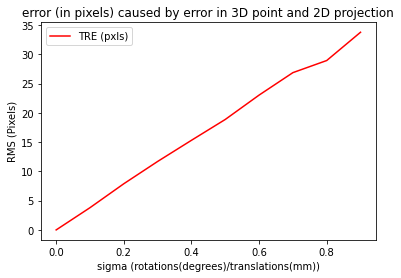

In [26]:

number_samples = 1000
x_values_px = []
y_values_px = []

x_values_mm = []
y_values_mm = []

for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # add noise to 3D points
        noisy_points = add_noise_to_points(points, sigma)
        
        # project both noisy and non-noisy 3D points to 2D
        image_points, _ = cv2.projectPoints(points_converted, rvec, tvec, intrinsics, distortion)
        image_points_noisy, _ = cv2.projectPoints(noisy_points, rvec, tvec, intrinsics, distortion)
        image_points = image_points.squeeze()
        image_points_noise_3D = image_points_noisy.squeeze()
        print(image_points_noise_3D)
        # add noise to 2D points
        image_points_noisy = add_noise_to_points(image_points_noise_3D,sigma)
        print(image_points_noisy)
        
        # try and match noisy 2D to original 3d object points and get transformation
        # true
        success_true, rotation_vector_true, translation_vector_true = cv2.solvePnP(points.astype('float32'), image_points.astype('float32'), intrinsics, distortion, flags=0 )
        # noisy
        success, rotation_vector, translation_vector = cv2.solvePnP(noisy_points.astype('float32'), image_points_noisy.astype('float32'), intrinsics, distortion, flags=0 )
        
        # project cancer 3D point using the found rotations and translations
        # true
        cancer_projected2D_true, _ = cv2.projectPoints(cancer_point, rotation_vector_true, translation_vector_true, intrinsics, distortion)
        cancer_projected2D_true = cancer_projected2D_true.squeeze()
        # noisy
        cancer_projected2D, _ = cv2.projectPoints(cancer_point, rotation_vector, translation_vector, intrinsics, distortion)
        cancer_projected2D = cancer_projected2D.squeeze()

        
        euclid_dist_px =  (cancer_projected2D_true[0] - cancer_projected2D[0]) \
                     * (cancer_projected2D_true[0] - cancer_projected2D[0]) \
                     + (cancer_projected2D_true[1] - cancer_projected2D[1]) \
                     * (cancer_projected2D_true[1] - cancer_projected2D[1]) 
        
        
        #euclid_dist_mm = calculate_euclid_dist()
        
        rms = rms + euclid_dist_px
        
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values_px.append(sigma)
    y_values_px.append(rms)
    
plt.plot(x_values_px, y_values_px, 'r', label='TRE (pxls)')
plt.title('error (in pixels) caused by error in 3D point and 2D projection')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (Pixels)')
plt.show()


In [23]:
image_points_noisy

array([[ 594.94403752,  318.831633  ],
       [ 591.10874781,  722.81518227],
       [1274.70869885,  725.66529804],
       [1278.84935741,  314.08008374]])

In [25]:
add_noise_to_points(image_points_noisy, 0.5)

array([[ 594.89278372,  319.55269588],
       [ 590.62285709,  722.1702238 ],
       [1274.65243724,  726.13398596],
       [1279.53351453,  314.84345158]])